In [1]:
# importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import glob # to access pathways for multiple csv calls

In [2]:
# all csv into one dataframe
list_all = [pd.read_csv(filename) for filename in glob.glob('./data/*.csv')]
df = pd.concat(list_all,axis=0) # concat row-wise
df.head()

,sale_time,purchaser_gender
0,2012-10-01 01:42:22,female
1,2012-10-01 02:24:53,female
2,2012-10-01 02:25:40,female
3,2012-10-01 02:30:42,female
4,2012-10-01 02:51:32,male


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204329 entries, 0 to 4998
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   sale_time         204329 non-null  object
 1   purchaser_gender  204329 non-null  object
dtypes: object(2)
memory usage: 4.7+ MB


In [4]:
sale_day = pd.to_datetime(df['sale_time']) # change to datetime to use related functions
print(sale_day.head())

# groupby day -> rename axis(time -> day) / get size(sales count each day) -> rename index(sales_count)
# daily_sales = sale_day.groupby(sale_day.dt.floor('d')).size().rename_axis('sale_day').reset_index(name='sales_count')
daily_sales = sale_day.groupby(sale_day.dt.floor('d')).size().rename_axis('sale_day')

print(daily_sales.head())

0   2012-10-01 01:42:22
1   2012-10-01 02:24:53
2   2012-10-01 02:25:40
3   2012-10-01 02:30:42
4   2012-10-01 02:51:32
Name: sale_time, dtype: datetime64[ns]
sale_day
2012-10-01    514
2012-10-02    482
2012-10-03    499
2012-10-04    546
2012-10-05    476
Name: sale_time, dtype: int64


0   2012-10-01 01:42:22
1   2012-10-01 02:24:53
2   2012-10-01 02:25:40
3   2012-10-01 02:30:42
4   2012-10-01 02:51:32
Name: sale_time, dtype: datetime64[ns]
    sale_day  sales_count
0 2012-10-01          514
1 2012-10-02          482
2 2012-10-03          499
3 2012-10-04          546
4 2012-10-05          476


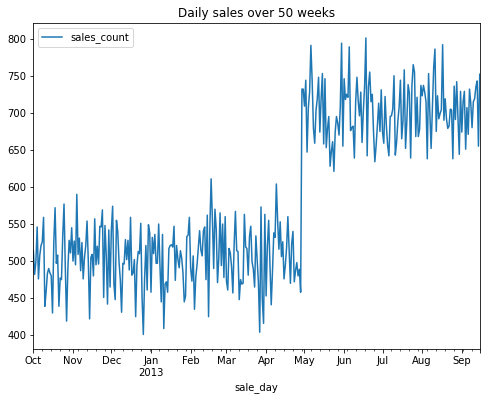

In [5]:
# 1. Plot daily sales for all 50 weeks.

# To do this : sale_time -> sale_day (use groupby...day)

# get daily sales
sale_day = pd.to_datetime(df['sale_time']) # change to datetime to use related functions
print(sale_day.head())

# groupby day -> rename axis(time -> day) / get size(sales count each day) -> rename index(sales_count)
daily_sales = sale_day.groupby(sale_day.dt.floor('d')).size().rename_axis('sale_day').reset_index(name='sales_count')
print(daily_sales.head())

# plot
#  move sale_day to index for plotting
daily_sales.index = daily_sales['sale_day']
daily_sales.drop(columns=['sale_day'], inplace=True)

#  plot daily sales for all 50 weeks
daily_sales.plot(figsize=(8,6), title = "Daily sales over 50 weeks")
plt.show()



In [6]:
daily_sales

,sales_count
sale_day,
2012-10-01,514
2012-10-02,482
2012-10-03,499
2012-10-04,546
2012-10-05,476
...,...
2013-09-11,719
2013-09-12,735
2013-09-13,743


In [7]:
# 2. Identify the date on which a sudden change in daily sales occurred.
daily_sales['prev_day_count'] = [None] + daily_sales['sales_count'].to_list()[:-1]
daily_sales['change_in_sales'] = abs(daily_sales['sales_count'] - daily_sales['prev_day_count'])
max_idx = daily_sales['change_in_sales'].idxmax()
print("Date of sudden change in daily sales occurred :", max_idx)

Date of sudden change in daily sales occurred : 2013-04-29 00:00:00


In [13]:
select_date = '2013-04-29'

daily_sales[daily_sales.index == select_date]['sales_count'].values[0]

732

In [14]:
# 3. Is the change in daily sales at the date you selected statistically significant? If so, what is the p-value?
# scipy.stats : t-test and obtain p-value
from scipy import stats

# Drop all NAN
daily_sales.dropna(inplace=True)

# sales_count of the selected date : 732
# Compare the max change with all sales_count column 
# to understand its statistical importance
pval = stats.ttest_1samp(daily_sales['sales_count'], 732).pvalue

# Define the significance level (alpha)
alpha = 0.05

# Check if the p-value is less than alpha
if pval < alpha:
    print(f"The change in daily sales on 2013-04-29 is statistically significant (p-value = {pval}).")
else:
    print(f"The change in daily sales on 2013-04-29 is not statistically significant (p-value = {pval}).")


The change in daily sales on 2013-04-29 is statistically significant (p-value = 1.3019593251472396e-84).


In [10]:
# from scipy.stats import wilcoxon

# # Identify the date of the sudden change
# change_date = '2013-04-29'

# # Get the sales count for the identified date
# sales_at_change_date = daily_sales.loc[change_date, 'sales_count']

# # Get the sales count for the previous day
# previous_date = pd.to_datetime(change_date) - pd.DateOffset(days=1)
# sales_previous_day = daily_sales.loc[previous_date.strftime('%Y-%m-%d'), 'sales_count']

# # Calculate the difference in sales
# sales_difference = abs(sales_at_change_date - sales_previous_day)

# # Perform Wilcoxon signed-rank test
# statistic, p_value = wilcoxon([sales_difference])

# # Define the significance level (alpha)
# alpha = 0.05

# # Check if the p-value is less than alpha
# if p_value < alpha:
#     print(f"The change in daily sales on {change_date} is statistically significant (p-value = {p_value}).")
# else:
#     print(f"The change in daily sales on {change_date} is not statistically significant (p-value = {p_value}).")


In [15]:
# 4. Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers? 
# Please use plots to support your answer (a rigorous statistical analysis is not necessary).
df['sale_day'] = pd.to_datetime(df['sale_time']).dt.floor('d')
grp_by_gender = df.groupby(['sale_day', 'purchaser_gender']).size().reset_index(name = 'sales_count')
grp_by_gender

,sale_day,purchaser_gender,sales_count
0,2012-10-01,female,413
1,2012-10-01,male,101
2,2012-10-02,female,379
3,2012-10-02,male,103
4,2012-10-03,female,386
...,...,...,...
695,2013-09-13,male,537
696,2013-09-14,female,193
697,2013-09-14,male,462
698,2013-09-15,female,230


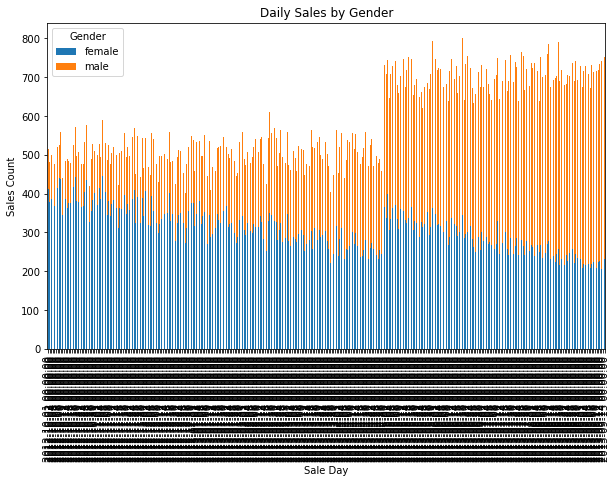

In [18]:
import matplotlib.pyplot as plt

# Pivot the data to have 'sale_day' as the index and 'purchaser_gender' as columns
pivot_df = grp_by_gender.pivot(index='sale_day', columns='purchaser_gender', values='sales_count')

# Create a stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Daily Sales by Gender')
plt.xlabel('Sale Day')
plt.ylabel('Sales Count')
plt.legend(title='Gender')
plt.show()


In [17]:
grp_by_gender[grp_by_gender['sale_day'] == select_date]

,sale_day,purchaser_gender,sales_count
420,2013-04-29,female,383
421,2013-04-29,male,349
